### ASTR-598, Winter 2018, Connolly & Ivezic, University of Washington
https://github.com/dirac-institute/uw-astr598-w18/tree/master/lectures/Week-5-Tue.ipynb


# Homework 3 (with solutions) 


### Homework #3  

Last time we discussed fitting a burst + background model, with two types 
of burst profile: exponential decay and a gaussian profile. Let's now
assume that we do not know which profile fits best and fit both profiles. 

With Group 1 generating data using the exponential decay profile, and 
Group 2 using the gaussian profile (with the same parameters as in the
lecture): 

1) Can you tell which model is correct using global likelihood computation?

2) Can you tell which model is correct using BIC?

3) What happens when you increase the number of data points by a factor of 2
    (using BIC)?

4) What happens when you decrease the number of data points by a factor of 2
     (using BIC)?



 [-----------------100%-----------------] 25000 of 25000 complete in 6.7 sec 
chi2dof = 0.9472514538720522


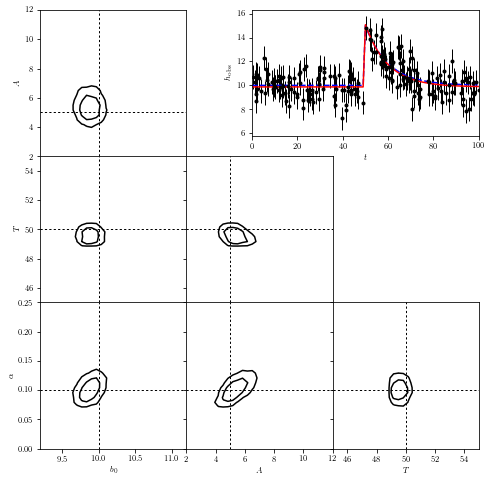

In [160]:
## burst profile
import numpy as np
from matplotlib import pyplot as plt

# Hack to fix import issue in older versions of pymc
import scipy
import scipy.misc
scipy.derivative = scipy.misc.derivative
import pymc

from astroML.plotting.mcmc import plot_mcmc
from astroML.decorators import pickle_results

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=True)

#----------------------------------------------------------------------
def get_logp(S, model):
    """compute log(p) given a pyMC model"""
    M = pymc.MAP(model)
    traces = np.array([S.trace(s)[:] for s in S.stochastics])
    logp = np.zeros(traces.shape[1])
    for i in range(len(logp)):
        logp[i] = -M.func(traces[:, i])
    return logp

#----------------------------------------------------------------------
# Set up toy dataset
def burst(t, b0, A, alpha, T):
    """Burst model"""
    y = np.empty(t.shape)
    y.fill(b0)
    mask = (t >= T)
    y[mask] += A * np.exp(-alpha * (t[mask] - T))
    return y

np.random.seed(0)

Ndata = 200
sigmaD = 1.0 

b0_true = 10
A_true = 5
alpha_true = 0.1
T_true = 50
err0_y = sigmaD

t = 100 * np.random.random(Ndata)
y_true = burst(t, b0_true, A_true, alpha_true, T_true)
y_obs = np.random.normal(y_true, sigmaD)

#----------------------------------------------------------------------
# Set up MCMC sampling
b0 = pymc.Uniform('b0', 0, 50, value=50 * np.random.random())
A = pymc.Uniform('A', 0, 50, value=50 * np.random.random())
T = pymc.Uniform('T', 0, 300, value=100 * np.random.random())
log_alpha = pymc.Uniform('log_alpha', -10, 10, value=0)


# uniform prior on log(alpha)
@pymc.deterministic
def alpha(log_alpha=log_alpha):
    return np.exp(log_alpha)


@pymc.deterministic
def y_modelB(t=t, b0=b0, A=A, alpha=alpha, T=T):
    return burst(t, b0, A, alpha, T)

y = pymc.Normal('y', mu=y_modelB, tau=sigmaD ** -2, observed=True, value=y_obs)

model = dict(b0=b0, A=A, T=T, log_alpha=log_alpha,
             alpha=alpha, y_model=y_modelB, y=y)


#----------------------------------------------------------------------
# Run the MCMC sampling
def compute_MCMC_results(niter=25000, burn=4000):
    S = pymc.MCMC(model)
    S.sample(iter=niter, burn=burn)
    traces = [S.trace(s)[:] for s in ['b0', 'A', 'T', 'alpha']]

    logp = get_logp(S, model)

    traceVstack = np.vstack([S.trace('b0')[:],
                        S.trace('A')[:],
                        S.trace('T')[:],
                        S.trace('alpha')[:]])

    M = pymc.MAP(model)
    M.fit()
    fit_vals = (M.b0.value, M.A.value, M.alpha.value, M.T.value)

    return traces, fit_vals, traceVstack, logp

traces, fit_vals, traceVstack, logp = compute_MCMC_results()

labels = ['$b_0$', '$A$', '$T$', r'$\alpha$']
limits = [(9.2, 11.2), (2, 12), (45, 55), (0.0, 0.25)]
true = [b0_true, A_true, T_true, alpha_true]

#------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(7, 7))
fig.subplots_adjust(bottom=0.1, top=0.95,
                    left=0.1, right=0.95,
                    hspace=0.05, wspace=0.05)

# This function plots multiple panels with the traces
plot_mcmc(traces, labels=labels, limits=limits, true_values=true, fig=fig,
          bins=30, colors='k')

# Plot the model fit
ax = fig.add_axes([0.5, 0.7, 0.45, 0.25])
t_fit = np.linspace(0, 100, 101)
y_fit = burst(t_fit, *fit_vals)
y_true = burst(t_fit, b0_true, A_true, alpha_true, T_true)

ax.scatter(t, y_obs, s=9, lw=0, c='k')
ax.errorbar(t, y_obs, sigmaD, fmt='.', lw=1, c='k')
ax.plot(t_fit, y_true, '--', c='blue')
ax.plot(t_fit, y_fit, '-k', c='red')
ax.set_xlim(0, 100)
ax.set_xlabel('$t$')
ax.set_ylabel(r'$h_{\rm obs}$')

## compute chi2dof
# first compute chi2: sum{[(y_obs-y_fit)/sigma_y]^2} 
# recompute y_fit on the data t grid 
y_fit = burst(t, *fit_vals)
chi2 = np.sum(((y_obs-y_fit)/sigmaD)**2) 
# and chi2 per degree of freedom (the number of fitted parameters is 4)
chi2dof = chi2/(Ndata - 4)
print ' '
print 'chi2dof =', chi2dof

plt.show()

 [-----------------100%-----------------] 25000 of 25000 complete in 6.5 sec 
chi2dof = 1.1347208806035962


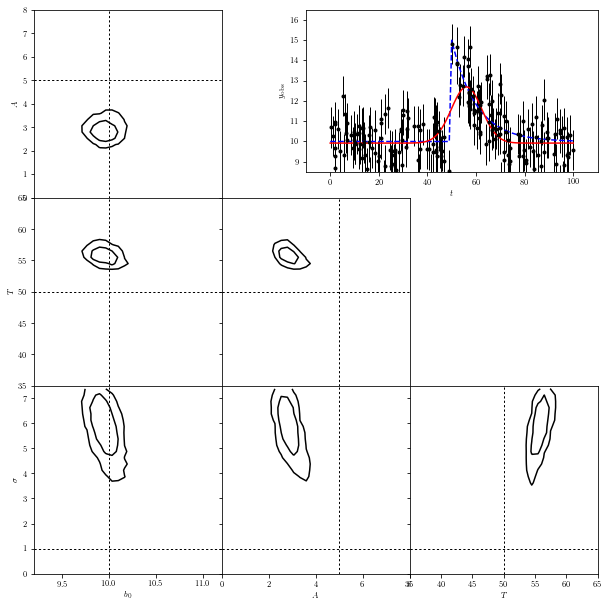

In [161]:
## burst "data set" analyzed using gaussian model profile
def GaussAndBkgd(t, b0, A, sigW, T):
    """Gaussian profile + flat background model"""
    y = np.empty(t.shape)
    y.fill(b0)
    y += A * np.exp(-(t - T)**2/2/sigW**2)
    return y

sigma_true = 1.0
labels = ['$b_0$', '$A$', '$T$', r'$\sigma$']
limits = [(9.2, 11.2), (0, 8), (35, 65), (0.0, 7.5)]
true = [b0_true, A_true, T_true, sigma_true]

#----------------------------------------------------------------------
# Set up MCMC sampling
b0 = pymc.Uniform('b0', 0, 50, value=50 * np.random.random())
A = pymc.Uniform('A', 0, 50, value=50 * np.random.random())
T = pymc.Uniform('T', 0, 300, value=100 * np.random.random())
log_sigma = pymc.Uniform('log_sigma', -2, 2, value=0.1)


# uniform prior on log(alpha)
@pymc.deterministic
def sigma(log_sigma=log_sigma):
    return np.exp(log_sigma)


@pymc.deterministic
def y_modelG(t=t, b0=b0, A=A, sigma=sigma, T=T):
    return GaussAndBkgd(t, b0, A, sigma, T)

y = pymc.Normal('y', mu=y_modelG, tau=sigmaD ** -2, observed=True, value=y_obs)

model = dict(b0=b0, A=A, T=T, log_sigma=log_sigma, sigma=sigma, y_model=y_modelG, y=y)

#----------------------------------------------------------------------
# Run the MCMC sampling
#@pickle_results('matchedfilt_gauss.pkl')
def compute_MCMC_results(niter=25000, burn=4000):
    S = pymc.MCMC(model)
    S.sample(iter=niter, burn=burn)
    traces = [S.trace(s)[:] for s in ['b0', 'A', 'T', 'sigma']]

    traceVstack = np.vstack([S.trace('b0')[:],
                    S.trace('A')[:],
                    S.trace('T')[:],
                    S.trace('sigma')[:]])

    logp = get_logp(S, model)

    M = pymc.MAP(model)
    M.fit()
    fit_vals = (M.b0.value, M.A.value, M.sigma.value, M.T.value)

    return traces, fit_vals, traceVstack, logp 

tracesG, fit_valsG, traceVstackG, logpG  = compute_MCMC_results()

#------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(9, 9))
fig.subplots_adjust(bottom=0.1, top=0.95,
                    left=0.1, right=0.95,
                    hspace=0.05, wspace=0.05)

# This function plots multiple panels with the traces
plot_mcmc(tracesG, labels=labels, limits=limits, true_values=true, fig=fig,
          bins=30, colors='k')

# Plot the model fit
ax = fig.add_axes([0.5, 0.7, 0.45, 0.25])
t_fit = np.linspace(0, 100, 101)
y_fit = GaussAndBkgd(t_fit, *fit_valsG)
#y_true = GaussAndBkgd(t_fit, b0_true, A_true, sigma_true, T_true)

ax.scatter(t, y_obs, s=9, lw=0, c='k')
ax.errorbar(t, y_obs, err0_y, fmt='.', lw=1, c='k')
ax.plot(t_fit, y_true, '--', c='blue')
ax.plot(t_fit, y_fit, '-k', c='red')
ax.set_xlim(-10, 110)
ax.set_ylim(8.5, 16.5)
ax.set_xlabel('$t$')
ax.set_ylabel(r'$y_{\rm obs}$')

## compute chi2dof
# first compute chi2: sum{[(y_obs-y_fit)/sigma_y]^2} 
# recompute y_fit on the data t grid 
y_fit = GaussAndBkgd(t, *fit_valsG)
chi2 = np.sum(((y_obs-y_fit)/err0_y)**2) 
# and chi2 per degree of freedom (the number of fitted parameters is 4)
chi2dof = chi2/(Ndata - 4)
print ' '
print 'chi2dof =', chi2dof

plt.show()

In [124]:
from sklearn.neighbors import BallTree
from astroML.density_estimation import GaussianMixture1D
from scipy.special import gamma

def estimate_bayes_factor(traces, logp, r=0.05, return_list=False):
    """Estimate the bayes factor using the local density of points"""
    D, N = traces.shape

    # compute volume of a D-dimensional sphere of radius r
    Vr = np.pi ** (0.5 * D) / gamma(0.5 * D + 1) * (r ** D)

    # use neighbor count within r as a density estimator
    bt = BallTree(traces.T)
    count = bt.query_radius(traces.T, r=r, count_only=True)

    BF = logp + np.log(N) + np.log(Vr) - np.log(count)

    if return_list:
        return BF
    else:
        p25, p50, p75 = np.percentile(BF, [25, 50, 75])
        return p50, 0.7413 * (p75 - p25)


In [158]:
BF, dBF = estimate_bayes_factor(traceVstack, logp, r=0.02)
print BF, dBF 

-1677.1870787119708 0.9875262511782537


In [159]:
BFG, dBFG = estimate_bayes_factor(traceVstackG, logpG, r=0.02)
print BFG, dBFG 

-1696.0658841102743 1.2981793972396363


In [ ]:
#  N     error      BF      BFG    dBF
# 200     1.0    -300.0   -316.3  16.3 
#  50     1.0     -89.0    -93.5   4.5
#  50     0.5     -55.4    -74.0  18.6
#  50     0.1      24.0   -349.5 373.5 
# 800     2.0     -1677    -1696   19 